In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from data_ps1.npz
data = np.load('data_ps1.npz')
environment_map = data['environment']
robot_shape = data['rod']

# Define robot configuration space parameters
num_orientations = robot_shape.shape[2]
robot_size = robot_shape.shape[0]
workspace_size = environment_map.shape[0]

**Task 1A: Visualize from the given data the workspace and the different rod configurations for each discretized
orientation**

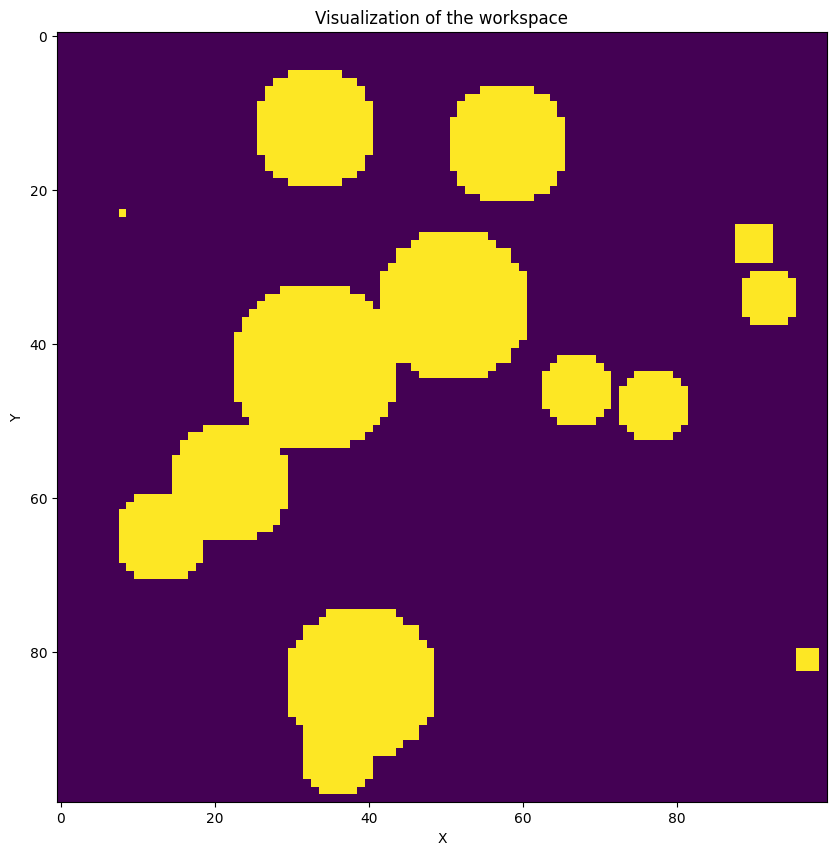

In [2]:
# Visualize the workspace
plt.figure(figsize=(10, 10))
plt.imshow(environment_map)
plt.title('Visualization of the workspace')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

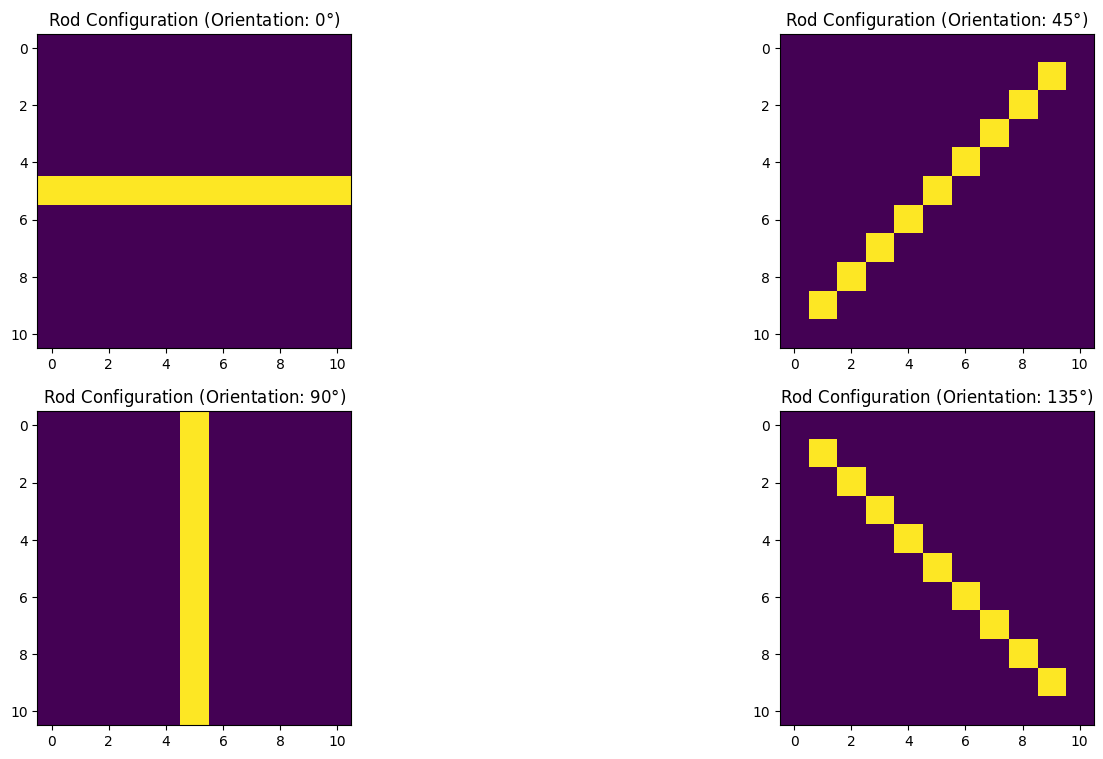

In [3]:
# Visualize the different rod configurations for each discretized orientation
plt.figure(figsize=(15, 15))
for theta_index in range(num_orientations):
    plt.subplot(num_orientations, 2, theta_index + 1)
    plt.imshow(robot_shape[:, :, theta_index])
    plt.title(f'Rod Configuration (Orientation: {theta_index * 45}$\degree$)')

plt.tight_layout()
plt.show()

**Task 1B: Visualize the environment together with the object**

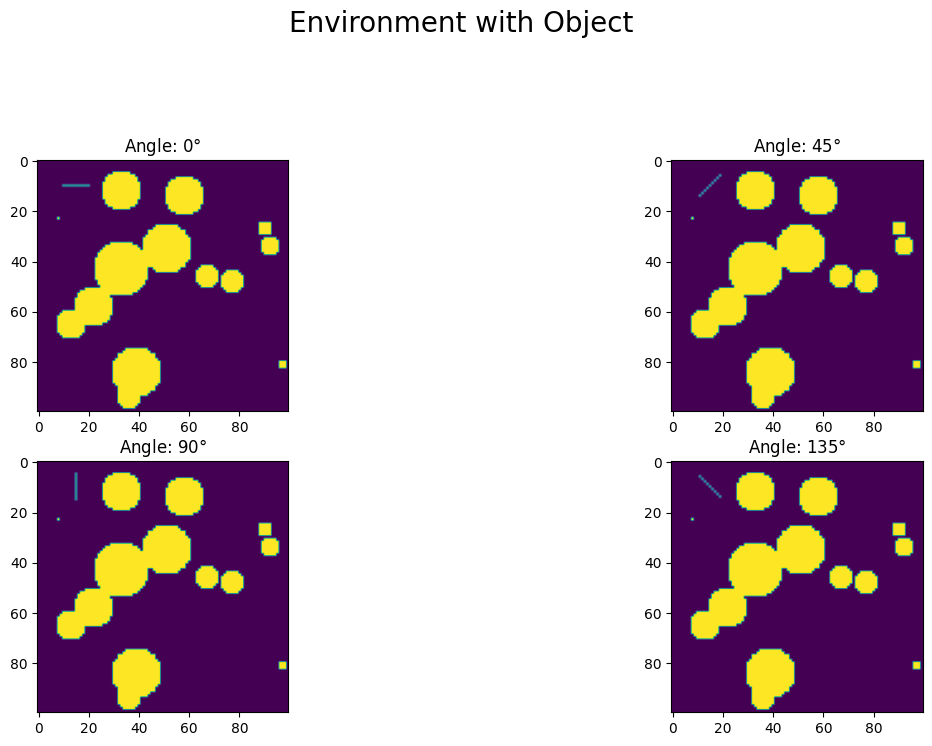

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_enviroment

#select any valid configuration value for the rod
#let's use initial position (10, 15)

coord_x = 10
coord_y = 15

pos = [0, 0, 0, 0]

#get different positions with initial position (10, 15) and angle variations (0, 45, 90, 135)
for j in range(4):
    pos[j] = plot_enviroment(environment_map, robot_shape, [coord_x, coord_y, j])
    
# Plot the result
plt.figure(figsize=(15, 15))
plt.suptitle('Environment with Object', fontsize=20)
for i in range(4):
    plt.subplot(4, 2, i + 1)
    plt.imshow(pos[i]) 
    plt.title(f'Angle: {i * 45}$\degree$', fontsize=12)
plt.show()


**Task 1C: Create the C-space for the 2D environment map. For this, plot all the images corresponding to each of the orientations by using collision checking**

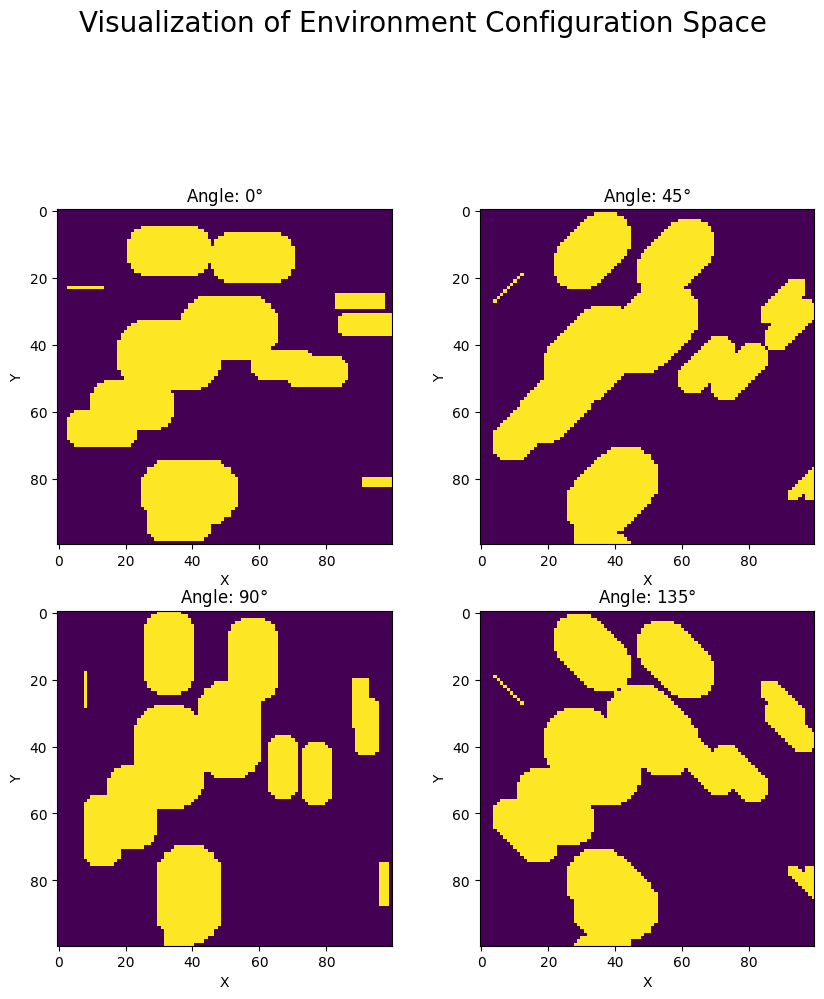

In [5]:
from scipy.signal import convolve2d
from utils import normalize_image
import scipy as sp

conf = [0, 0, 0, 0]
norm_conf = [0, 0, 0, 0]

# Get the maps and normalize images
for i in range(4):
    conf[i] = sp.signal.convolve2d(environment_map, robot_shape[:, :, i], boundary='symm', mode='same')
    norm_conf[i] = normalize_image(conf[i])
    
# Define figure properties and suptitle
plt.figure(figsize = (10, 20))
plt.suptitle('Visualization of Environment Configuration Space', fontsize=20)
    
for i in range(4):
    plt.subplot(4, 2, i+1)
    plt.imshow(norm_conf[i])
    plt.title(f'Angle: {i * 45}$\degree$', fontsize=12)
    plt.xlabel('X')
    plt.ylabel('Y')    

**Task 1D: Comment on the obtained C-space with the previous method. What is the size of the C-space?**
The size of configuration space is (X, Y, $\theta$), where X = 100, Y = 100, angle $\theta$ represents the different discretization orientations - the robot rotated by 0, 45, 90, 135 degrees positions

**Task 2A: You need to implement the A star algorithm and plan in the generated discrete C-space from the
previous task. The starting configuration of the agent is (6,6,2) and the goal configuration is (55,55,0). On
this first iteration, use an heuristic function h(q; qG) = 0, which is equivalent to the Dijkstra algorithm.**

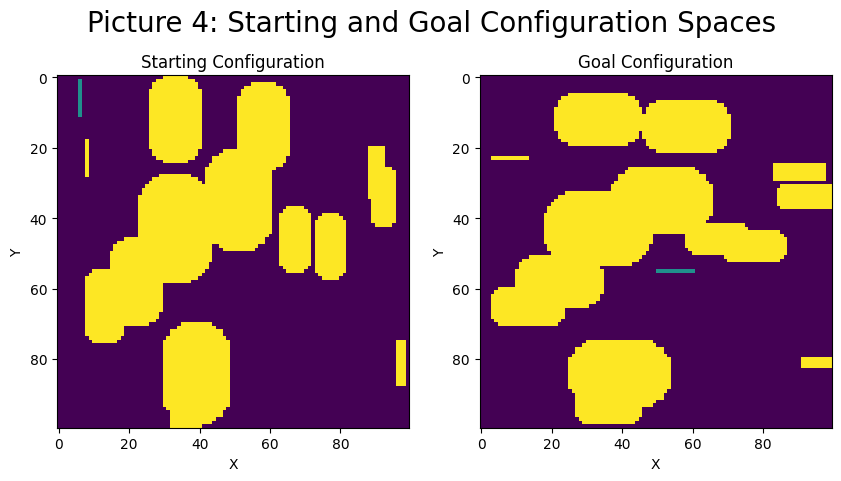

In [6]:
# Point the starting position of the rod and the goal position
start_config = plot_enviroment(norm_conf[2], robot_shape, [6, 6, 2])
goal_config = plot_enviroment(norm_conf[0], robot_shape, [55, 55, 0])

# Plot the starting configuration and the goal one
plt.figure(figsize=(10, 5))
plt.suptitle('Picture 4: Starting and Goal Configuration Spaces', fontsize=20)

plt.subplot(1, 2, 1)
plt.imshow(start_config)
plt.title('Starting Configuration')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 2, 2)
plt.imshow(goal_config)
plt.title('Goal Configuration')
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

In [7]:
from heapq import *

# Define function to change the angle
def change_angle(pos):
    """
    Change the angle of the configuration space,
    if point out of boundaries:
    3 -> 0
    0 -> 3
    """
    
    pos[2] = 0 if pos[2] > 3 else 3 if pos[2] < 0 else pos[2]
    return pos

# Define function to check if we are in boundaries
def check_boundaries(pos, configuration_space):
    """
    Check if the object is placed inside environment.
    Take into account object size (-5 each side).
    """
    return True if (pos[0] > 5) and (pos[0] < 95) and (pos[1] > 5) and pos[1] < 95 \
and configuration_space[pos[0], pos[1], pos[2]] == 0 else False
 

# Initial conditions
configuration_space = np.dstack((norm_conf[0], norm_conf[1], norm_conf[2], norm_conf[3]))
start = tuple(np.array((6, 6, 2)))
goal = tuple(np.array((55, 55, 0)))


# Define Dijsktra algorithm
def find_path_dijkstra(start, goal, configuration_space):
    """ Find a path with a dijkstra algorithm

    Args:
        start - starting position [x, y, theta]
        goal - goal position [x, y, theta]
        configuration_space - configuration space consists of discretized variety of configurations
    
    Returns:
        plan - pathway to the goal point
        plan_length - pathway length
        visited_nodes - amount of visited nodes
    """
    # Initialize priority queue
    Q = []
    
    # Initialize cost list
    C = np.zeros((100, 100, 4))
    # Initialize possible actions
    U = (np.array((0, -1, 0)), 
        np.array((0, 1, 0)), 
        np.array((1, 0, 0)), 
        np.array((-1, 0, 0)),
        np.array((0, 0, -1)),
        np.array((0, 0, 1))
         )
    # Assign cost for the starting node
    C[start] = 0
    # Put starting position and assign a cost
   # Q.put((C[tuple(start)], tuple(start)))
    heappush(Q, ( C[start], start))
    # Action cost
    action_cost = 1
    # Initialize array of visited points
    visited = np.zeros((100, 100, 4))
    # Initialize parent table
    parent_table = {}
    # Initialize plan
    plan = 0
    while Q:
        #X = Q.get()[1]             # X - current position in configuration space
        X = heappop(Q)[1]
        if X == goal:     # If the current position satisfies the goal position
            flag = True            # Raise the flag to show the message
            break                  # Exit the cycle
        for coordinate in U:      # For each possible action in dictionary U
                X_dot =  X + coordinate           # Tranform the position to new coordinate in configuration space, X_dot - new state in the configuration space
                #if (X_dot[2] > 3) or (X_dot[2] < 0):    # If angle is out of boundaries
                X_dot = change_angle(X_dot)         # Function to change the angle
                if check_boundaries(X_dot, configuration_space):  # Checking the obstacle and borders
                    X_dot = tuple(X_dot)
                    X = tuple(X)
                    if visited[X_dot] == True:
                        current_cost = C[X] + action_cost
                        if current_cost < C[X_dot]:
                            C[X_dot] = current_cost
                            parent_table[X_dot] = X
                    else:
                        visited[X_dot] = True
                        C[X_dot] = C[X] + action_cost
                        parent_table[X_dot] = X
                        heappush(Q, ( C[X_dot], X_dot))
    if flag:
        print('------------------------')
        print('Dijkstra status: Success')

        # Get the amount of visited nodes
        visited_nodes = len(parent_table)
        print('Amount of visited nodes: ', visited_nodes)

        # Get the plan 
        plan = [goal]
        while plan[-1] != start:
            plan.append(parent_table[plan[-1]])

    # Reverse the plan: From Start to Goal
        plan = plan[::-1]

        # Get the length of the pathway plan
        plan_length = len(plan)
        print('Plan length: ', plan_length)

        # Get the final cost
        final_cost = C[goal]
        print('Final cost: ', final_cost)
        print('------------------------')
    else:
        print('Dijkstra status: Failure')

    return (plan, plan_length, visited_nodes, final_cost)


# Call Dijkstra algorithm
dijkstra = find_path_dijkstra(start, goal, configuration_space)

------------------------
Dijkstra status: Success
Amount of visited nodes:  11637
Plan length:  117
Final cost:  116.0
------------------------


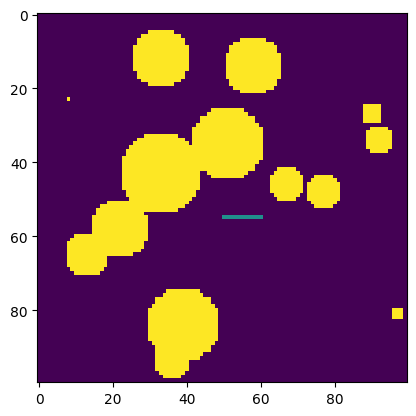

In [8]:
import utils
utils.plotting_results(environment_map, robot_shape, dijkstra[0], 'rod_solve.gif')

**B: Change the heuristic function now to be h(q, qG) = L1 norm of the x, y components. How many states have been visited compared to Dijkstra? What is the final cost?**

In [9]:
from heapq import *

# Define function to change the angle
def change_angle(pos):
    """
    Change the angle of the configuration space,
    if point out of boundaries:
    3 -> 0
    0 -> 3
    """
    
    pos[2] = 0 if pos[2] > 3 else 3 if pos[2] < 0 else pos[2]
    return pos

# Define function to check if we are in boundaries
def check_boundaries(pos, configuration_space):
    """
    Check if the object is placed inside environment.
    Take into account object size (-5 each side).
    """
    return True if (pos[0] > 5) and (pos[0] < 95) and (pos[1] > 5) and pos[1] < 95 \
and configuration_space[pos[0], pos[1], pos[2]] == 0 else False
 

def heuristic(goal, dot):
    return np.abs(goal[0] - dot[0]) + np.abs(goal[1] - dot[1]) 
    
# Initial conditions
configuration_space = np.dstack((norm_conf[0], norm_conf[1], norm_conf[2], norm_conf[3]))
start = tuple(np.array((6, 6, 2)))
goal = tuple(np.array((55, 55, 0)))


# Define Dijsktra algorithm
def find_path_A_star(start, goal, configuration_space):
    """ Find a path with a dijkstra algorithm

    Args:
        start - starting position [x, y, theta]
        goal - goal position [x, y, theta]
        configuration_space - configuration space consists of discretized variety of configurations
    
    Returns:
        plan - pathway to the goal point
        plan_length - pathway length
        visited_nodes - amount of visited nodes
    """
    # Initialize priority queue
    Q = []
    # Initialize cost list
    C = np.zeros((100, 100, 4))
    # Initialize possible actions
    U = (np.array((0, -1, 0)), 
        np.array((0, 1, 0)), 
        np.array((1, 0, 0)), 
        np.array((-1, 0, 0)),
        np.array((0, 0, -1)),
        np.array((0, 0, 1))
         )
    # Assign cost for the starting node
    C[start] = 0
    C[goal] = 200

    # Put starting position and assign a cost
   # Q.put((C[tuple(start)], tuple(start)))
    heappush(Q, (C[start], start))
    # Action cost
    action_cost = 1
    # Initialize array of visited points
    visited = np.zeros((100, 100, 4))
    # Initialize parent table
    parent_table = {}
    # Initialize plan
    plan = 0
    while Q:
        #X = Q.get()[1]             # X - current position in configuration space
        X = heappop(Q)[1]
        if X == goal:     # If the current position satisfies the target position
            flag = True            # Raise the flag to show the message
            break                  # Exit the cycle
        for coordinate in U:      # For each possible action in dictionary U
                X_dot =  X + coordinate           # Tranform the position to new coordinate in configuration space, X_dot - new state in the configuration space
                #if (X_dot[2] > 3) or (X_dot[2] < 0):    # If angle is out of boundaries
                X_dot = change_angle(X_dot)         # Function to change the angle
                if check_boundaries(X_dot, configuration_space):  # Checking the obstacle and borders
                    X_dot = tuple(X_dot)
                    X = tuple(X)
                    if visited[X_dot] == True:
                        current_cost = C[X] + action_cost
                        if current_cost < min(C[X_dot], C[goal]):
                            C[X_dot] = current_cost
                            parent_table[X_dot] = X
                    else:
                        visited[X_dot] = True
                        C[X_dot] = C[X] + action_cost
                        parent_table[X_dot] = X
                        heappush(Q, (C[X_dot] + heuristic(goal, X_dot), X_dot))
    if flag:
        print('------------------------')
        print('A_star status: Success')

        # Get the amount of visited nodes
        visited_nodes = len(parent_table)
        print('Amount of visited nodes: ', visited_nodes)

        # Get the plan 
        plan = [goal]
        while plan[-1] != start:
            plan.append(parent_table[plan[-1]])

    # Reverse the plan: From Start to Goal
        plan = plan[::-1]

        # Get the length of the pathway plan
        plan_length = len(plan)
        print('Plan length: ', plan_length)

        # Get the final cost
        final_cost = C[goal]
        print('Final cost: ', final_cost)
        print('------------------------')
    else:
        print('A_star status: Failure')

    return (plan, plan_length, visited_nodes, final_cost)


# Call A* algorithm
A_star = find_path_A_star(start, goal, configuration_space)

------------------------
A_star status: Success
Amount of visited nodes:  4486
Plan length:  117
Final cost:  116.0
------------------------


As we can see, in A* algorithm he amount of visited nodes is much less than in Dijkstra algorithm

**C: Propose an heuristic function $h(q, q_G)$ that includes orientation. Compare metrics with the previous
results. Comment on the results**

$h(q, q_G) = |\theta_{X} - \theta_{X_G}|$ a part of heuristic function that is responsible for the angle theta.

In [10]:
# Define function to change the angle
def change_angle(pos):
    """
    Change the angle of the configuration space,
    if point out of boundaries:
    3 -> 0
    0 -> 3
    """
    
    pos[2] = 0 if pos[2] > 3 else 3 if pos[2] < 0 else pos[2]
    return pos

# Define function to check if we are in boundaries
def check_boundaries(pos, configuration_space):
    """
    Check if the object is placed inside environment.
    Take into account object size (-5 each side).
    """
    return True if (pos[0] > 5) and (pos[0] < 95) and (pos[1] > 5) and pos[1] < 95 \
and configuration_space[pos[0], pos[1], pos[2]] == 0 else False
 

def heuristic(goal, dot):
    return np.abs(goal[0] - dot[0]) + np.abs(goal[1] - dot[1]) + np.abs(goal[2] - dot[2]) 
    
# Initial conditions
configuration_space = np.dstack((norm_conf[0], norm_conf[1], norm_conf[2], norm_conf[3]))
start = tuple(np.array((6, 6, 2)))
goal = tuple(np.array((55, 55, 0)))


# Define Dijsktra algorithm
def find_path_A_star(start, goal, configuration_space):
    """ Find a path with a dijkstra algorithm

    Args:
        start - starting position [x, y, theta]
        goal - goal position [x, y, theta]
        configuration_space - configuration space consists of discretized variety of configurations
    
    Returns:
        plan - pathway to the goal point
        plan_length - pathway length
        visited_nodes - amount of visited nodes
    """
    # Initialize priority queue
    Q = []
    # Initialize cost list
    C = np.zeros((100, 100, 4))
    # Initialize possible actions
    U = (np.array((0, -1, 0)), 
        np.array((0, 1, 0)), 
        np.array((1, 0, 0)), 
        np.array((-1, 0, 0)),
        np.array((0, 0, -1)),
        np.array((0, 0, 1))
         )
    # Assign cost for the starting node
    C[start] = 0
    C[goal] = 200

    # Put starting position and assign a cost
   # Q.put((C[tuple(start)], tuple(start)))
    heappush(Q, (C[start], start))
    # Action cost
    action_cost = 1
    # Initialize array of visited points
    visited = np.zeros((100, 100, 4))
    # Initialize parent table
    parent_table = {}
    # Initialize plan
    plan = 0
    while Q:
        #X = Q.get()[1]             # X - current position in configuration space
        X = heappop(Q)[1]
        if X == goal:     # If the current position satisfies the goal position
            flag = True            # Raise the flag to show the message
            break                  # Exit the cycle
        for coordinate in U:      # For each possible action in dictionary U
                X_dot =  X + coordinate           # Tranform the position to new coordinate in configuration space, X_dot - new state in the configuration space
                #if (X_dot[2] > 3) or (X_dot[2] < 0):    # If angle is out of boundaries
                X_dot = change_angle(X_dot)         # Function to change the angle
                if check_boundaries(X_dot, configuration_space):  # Checking the obstacle and borders
                    X_dot = tuple(X_dot)
                    X = tuple(X)
                    if visited[X_dot] == True:
                        current_cost = C[X] + action_cost
                        if current_cost < min(C[X_dot], C[goal]):
                            C[X_dot] = current_cost
                            parent_table[X_dot] = X
                    else:
                        visited[X_dot] = True
                        C[X_dot] = C[X] + action_cost
                        parent_table[X_dot] = X
                        heappush(Q, (C[X_dot] + heuristic(goal, X_dot), X_dot))
    if flag:
        print('------------------------')
        print('A_star status: Success')

        # Get the amount of visited nodes
        visited_nodes = len(parent_table)
        print('Amount of visited nodes: ', visited_nodes)

        # Get the plan 
        plan = [goal]
        while plan[-1] != start:
            plan.append(parent_table[plan[-1]])

    # Reverse the plan: From Start to Goal
        plan = plan[::-1]

        # Get the length of the pathway plan
        plan_length = len(plan)
        print('Plan length: ', plan_length)

        # Get the final cost
        final_cost = C[goal]
        print('Final cost: ', final_cost)
        print('------------------------')
    else:
        print('A_star status: Failure')

    return (plan, plan_length, visited_nodes, final_cost)


# Call Dijkstra algorithm
A_star = find_path_A_star(start, goal, configuration_space)

------------------------
A_star status: Success
Amount of visited nodes:  4352
Plan length:  117
Final cost:  116.0
------------------------


The amount of visited nodes reduced from 4486 to 4352. Plan length and final cost remained same

On this PS1 we used Dijkstra and A* algorithms to solve discrete planning problems. It is shown that A* algorithm works better (amount of visited node is less than in Dijkstra algorithm) because it takes into account heuristic function